## EDA and Data Cleaning

In [95]:
# Import libraries
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
import numpy as np
import gzip as gz
import seaborn as sns
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=(RuntimeWarning))
import itertools 
from zipfile import ZipFile
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor, NearestNeighbors
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, plot_roc_curve, plot_confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.decomposition import PCA
from xgboost import XGBClassifier 
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline
from collections import Counter
from statsmodels.api import qqplot
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

In [96]:
# Load and explore dataset
nba = 'NBAInjuries.zip'
with ZipFile(nba, 'r') as zip:
    zip.extractall('nba_unzipped')
    
df = pd.read_csv('nba_unzipped/injuries_2010-2020.csv')
df

,Date,Team,Acquired,Relinquished,Notes
0,2010-10-03,Bulls,NaN,Carlos Boozer,fractured bone in right pinky finger (out indefinitely)
1,2010-10-06,Pistons,NaN,Jonas Jerebko,torn right Achilles tendon (out indefinitely)
2,2010-10-06,Pistons,NaN,Terrico White,broken fifth metatarsal in right foot (out indefinitely)
3,2010-10-08,Blazers,NaN,Jeff Ayres,torn ACL in right knee (out indefinitely)
4,2010-10-08,Nets,NaN,Troy Murphy,strained lower back (out indefinitely)
...,...,...,...,...,...
27100,2020-09-30,Lakers,Dion Waiters,NaN,activated from IL
27101,2020-10-02,Heat,NaN,Bam Adebayo,strained neck (DTD)
27102,2020-10-02,Heat,NaN,Goran Dragic,placed on IL with torn plantar fascia in left foot
27103,2020-10-02,Heat,Chris Silva,NaN,activated from IL


In [97]:
# Drop Acquired column, null values, and rename Relinquished to Name
df.drop(['Acquired'], axis=1, inplace=True)
df.dropna(inplace=True)
df.rename(columns={'Relinquished':'Name'}, inplace=True)
df.head()

,Date,Team,Name,Notes
0,2010-10-03,Bulls,Carlos Boozer,fractured bone in right pinky finger (out indefinitely)
1,2010-10-06,Pistons,Jonas Jerebko,torn right Achilles tendon (out indefinitely)
2,2010-10-06,Pistons,Terrico White,broken fifth metatarsal in right foot (out indefinitely)
3,2010-10-08,Blazers,Jeff Ayres,torn ACL in right knee (out indefinitely)
4,2010-10-08,Nets,Troy Murphy,strained lower back (out indefinitely)


In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17558 entries, 0 to 27102
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    17558 non-null  object
 1   Team    17558 non-null  object
 2   Name    17558 non-null  object
 3   Notes   17558 non-null  object
dtypes: object(4)
memory usage: 685.9+ KB


In [99]:
# Create series of Notes column
s1 = df.Notes

In [100]:
out_for_season = s1.str.contains('out for season', case=False)
out_for_season.value_counts()

False    16433
True      1125
Name: Notes, dtype: int64

In [101]:
# Binary label out_of_season as target
df = df.assign(out_for_season=pd.Series(out_for_season).values)
df = df*1

# Dataset of injuries that resulted in player being 'out for season'
ofs = df[(df['Notes'].str.contains('out for season', case=False))]
ofs.head()

,Date,Team,Name,Notes,out_for_season
8,2010-10-12,Bucks,Darington Hobson,surgery on left hip (out for season),1
17,2010-10-26,Blazers,Greg Oden,placed on IL with left knee injury (out for season),1
75,2010-10-27,Pistons,Jonas Jerebko,placed on IL recovering from surgery to repair torn right Achilles tendon (out for season),1
76,2010-10-27,Pistons,Terrico White,placed on IL recovering from surgery on right foot to repair broken fifth metatarsal (out for season),1
175,2010-11-04,Blazers,Elliot Williams,"dislocated patella in right knee (surgery, out for season)",1


In [102]:
# Split injury data by season
ofs_10 = ofs[(ofs['Date'] < '2011-07-01')]
ofs_11 = ofs[(ofs['Date'].between('2011-07-01','2012-07-01'))]
ofs_12 = ofs[(ofs['Date'].between('2012-07-01','2013-07-01'))]
ofs_13 = ofs[(ofs['Date'].between('2013-07-01','2014-07-01'))]
ofs_14 = ofs[(ofs['Date'].between('2014-07-01','2015-07-01'))]
ofs_15 = ofs[(ofs['Date'].between('2015-07-01','2016-07-01'))]
ofs_16 = ofs[(ofs['Date'].between('2016-07-01','2017-07-01'))]
ofs_17 = ofs[(ofs['Date'].between('2017-07-01','2018-07-01'))]
ofs_18 = ofs[(ofs['Date'].between('2018-07-01','2019-07-01'))]

Multiple entries for same player and injury are noted. The duplicates need to be removed.

In [103]:
# Function to drop duplicates
def DropDuplicates(dataset):
    return dataset.drop_duplicates(subset=['Name'], inplace=True)

# Make list of season datasets
list_ofs = [ofs_10, ofs_11, ofs_12, ofs_13, ofs_14, ofs_15,
            ofs_16, ofs_17, ofs_18]

# Apply function
[DropDuplicates(season) for season in list_ofs]

<ipython-input-103-b83b864be86c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return dataset.drop_duplicates(subset=['Name'], inplace=True)


[None, None, None, None, None, None, None, None, None]

Import NBA player stats

In [104]:
# Import player stats
p09 = pd.read_excel('player_stats/2009-2010.xlsx')
p10 = pd.read_excel('player_stats/2010-2011.xlsx')
p11 = pd.read_excel('player_stats/2011-2012.xlsx')
p12 = pd.read_excel('player_stats/2012-2013.xlsx')
p13 = pd.read_excel('player_stats/2013-2014.xlsx')
p14 = pd.read_excel('player_stats/2014-2015.xlsx')
p15 = pd.read_excel('player_stats/2015-2016.xlsx')
p16 = pd.read_excel('player_stats/2016-2017.xlsx')
p17 = pd.read_excel('player_stats/2017-2018.xlsx')

# Read dummy 2018 data for chart
p18 = pd.read_excel('player_stats/2018-2019.xlsx')


# Make list of season datasets
list_p = [p10, p11, p12, p13, p14,
            p15, p16, p17, p18]

In [105]:
# Merge stats dataset with injury dataset
s09 = pd.merge(p09,ofs_10, how='left', on='Name')
s10 = pd.merge(p10,ofs_11, how='left', on='Name')
s11 = pd.merge(p11,ofs_12, how='left', on='Name')
s12 = pd.merge(p12,ofs_13, how='left', on='Name')
s13 = pd.merge(p13,ofs_14, how='left', on='Name')
s14 = pd.merge(p14,ofs_15, how='left', on='Name')
s15 = pd.merge(p15,ofs_16, how='left', on='Name')
s16 = pd.merge(p16,ofs_17, how='left', on='Name')
s17 = pd.merge(p17,ofs_18, how='left', on='Name')

Now let us build a chart to visualize the incidence of season ending injury in the NBA by season

In [106]:
# For loop calculating injury incidence
inj_incidence=[]
for inj,p in itertools.zip_longest(list_ofs,list_p):
    inj_incidence.append(len(inj.index)/len(p.index))

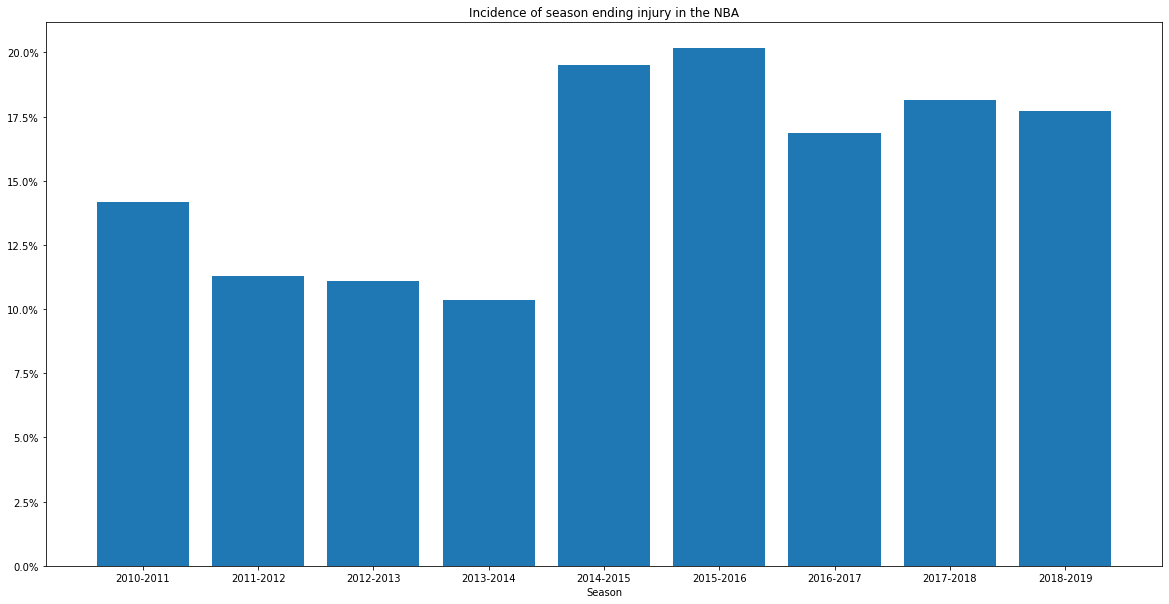

In [107]:
# Build chart
x=['2010-2011','2011-2012','2012-2013','2013-2014','2014-2015','2015-2016','2016-2017','2017-2018','2018-2019']
y=inj_incidence
fig, ax = plt.subplots(figsize=(20,10))
bars = ax.bar(x,y)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_xlabel('Season')
ax.set_title('Incidence of season ending injury in the NBA');

In [108]:
# Concatenate season datasets into main dataset
df_con = pd.concat([s09,s10,s11,s12,s13,s14,s15,s16,s17], axis=0)
df_con.head()

,Name,TEAM,AGE,HEIGHT,WEIGHT,COLLEGE,COUNTRY,DRAFT YEAR,DRAFT ROUND,DRAFT NUMBER,GP,NETRTG,TS%,W,L,MPG,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,+/-,MIN,USG%,%FGM,%FGA,%3PM,%3PA,%FTM,%FTA,%OREB,%DREB,%REB,%AST,%TOV,%STL,%BLK,%BLKA,%PF,%PFD,%PTS,Date,Team,Notes,out_for_season
0,Aaron Brooks,HOU,25,6-1,161,Oregon,USA,2007,1,26,82,0.2,0.549,42,40,35.6,19.6,7.0,16.2,43.2,2.5,6.4,39.8,3.0,3.6,82.2,0.7,2.0,2.6,5.3,2.8,0.8,0.2,2.4,30.9,6,0,-0.3,2919,25.4,25.1,26.2,41.5,37.8,22.5,21.1,8.1,8.8,8.6,32.7,27.0,16.2,6.2,21.3,16.3,19.7,26.0,NaN,NaN,NaN,NaN
1,Aaron Gray,NOH,25,7-1,270,Pittsburgh,USA,2007,2,49,32,-3.1,0.551,11,21,9.7,3.3,1.3,2.6,51.2,0.0,0.0,0.0,0.6,0.9,71.4,1.4,1.9,3.3,0.7,0.6,0.3,0.3,1.7,9.6,0,0,-0.4,311,16.0,17.2,15.4,0.0,0.0,21.5,23.1,52.3,30.8,37.3,16.5,18.0,18.0,35.5,25.0,37.5,18.5,16.9,NaN,NaN,NaN,NaN
2,Acie Law,CHI,25,6-3,202,Texas A&M,USA,2007,1,11,26,5.3,0.585,11,15,9.0,4.3,1.3,2.9,46.7,0.2,0.6,31.3,1.5,1.9,77.6,0.1,0.5,0.7,1.0,0.7,0.4,0.0,0.6,7.4,0,0,0.8,234,21.4,18.6,19.4,14.7,18.4,29.9,30.4,6.1,10.3,9.2,26.0,29.8,24.4,4.2,39.4,14.0,27.8,21.0,2011-03-29,Warriors,placed on IL with right wrist injury (out for season),1.0
3,Adam Morrison,LAL,25,6-8,205,Gonzaga,USA,2006,1,3,31,-8.3,0.418,23,8,7.8,2.4,1.0,2.7,37.6,0.2,0.7,23.8,0.2,0.3,62.5,0.3,0.7,1.0,0.6,0.3,0.1,0.1,0.5,4.7,0,0,-1.2,241,17.8,17.7,20.1,13.9,21.2,6.8,7.7,16.4,13.6,14.3,16.8,13.9,10.0,8.0,30.0,20.2,5.8,15.7,NaN,NaN,NaN,NaN
4,AJ Price,IND,23,6-2,181,Connecticut,USA,2009,2,52,56,3.9,0.530,23,33,15.5,7.3,2.6,6.3,41.0,1.1,3.1,34.5,1.1,1.3,80.0,0.2,1.4,1.6,1.9,1.1,0.6,0.1,0.9,13.0,0,0,0.9,865,21.9,21.3,23.2,32.4,34.3,19.2,18.0,7.4,13.4,12.1,27.4,21.5,25.5,3.2,23.8,13.6,20.2,22.0,NaN,NaN,NaN,NaN


Let the data cleaning begin

In [109]:
# Function to convert ft-in height into inches
def parse_ht(height):
    ht_ = height.split("-")
    ft_ = int(ht_[0])
    in_ = int(ht_[1])
    return (12*ft_) + in_
df_con["HEIGHT"] = df_con["HEIGHT"].apply(lambda x:parse_ht(x))

In [110]:
# Binary bin Country['USA'] = 1, other = 0
df_con.COUNTRY.replace(to_replace='USA', value=1, inplace=True) 
df_con.loc[df_con['COUNTRY'] != 1, 'COUNTRY'] = 0
df_con['COUNTRY'] = df_con['COUNTRY'].astype(int)
df_con.COUNTRY.value_counts()

1    3456
0     861
Name: COUNTRY, dtype: int64

In [111]:
# Binary bin College = 1 , no College = 0
df_con.COLLEGE.replace(to_replace='None', value=0, inplace=True)
df_con.loc[df_con['COLLEGE'] != 0, 'COLLEGE'] = 1
df_con['COLLEGE'] = df_con['COLLEGE'].astype(int)
df_con.COLLEGE.value_counts()

1    3572
0     745
Name: COLLEGE, dtype: int64

In [112]:
# Replace Undrafted and Nan with 0
df_con.replace(to_replace='Undrafted', value=0, inplace=True)
df_con['out_for_season'].fillna(0, inplace=True)

In [113]:
# DRAFT YEAR dropped because because undrafted player data was not recorded
df_con.drop('DRAFT YEAR', axis=1, inplace=True)

In [114]:
# Function to convert strings to numeric
def MakeNumeric(Column):
    df_con[Column] = df_con[Column].astype(int)
    return df_con

# Make list of columns to be convert to numeric values
make_columns_numeric = ['COUNTRY', 'COLLEGE', 'DRAFT ROUND', 'DRAFT NUMBER', 'out_for_season']

# Apply function
[MakeNumeric(column) for column in make_columns_numeric]

[              Name TEAM  AGE  HEIGHT  WEIGHT  COLLEGE  COUNTRY  DRAFT ROUND  \
 0     Aaron Brooks  HOU   25      73     161        1        1            1   
 1       Aaron Gray  NOH   25      85     270        1        1            2   
 2         Acie Law  CHI   25      75     202        1        1            1   
 3    Adam Morrison  LAL   25      80     205        1        1            1   
 4         AJ Price  IND   23      74     181        1        1            2   
 ..             ...  ...  ...     ...     ...      ...      ...          ...   
 535   Zach Collins  POR   20      85     230        1        1            1   
 536    Zach LaVine  CHI   23      77     185        1        1            1   
 537  Zach Randolph  SAC   36      81     250        1        1            1   
 538  Zaza Pachulia  GSW   34      83     270        0        0            2   
 539        Zhou Qi  HOU   22      85     210        0        0            2   
 
      DRAFT NUMBER  GP  NETRTG    TS% 

In [115]:
# Dummify Teams
df_con = pd.get_dummies(df_con, columns=['TEAM'])
df_con

,Name,AGE,HEIGHT,WEIGHT,COLLEGE,COUNTRY,DRAFT ROUND,DRAFT NUMBER,GP,NETRTG,TS%,W,L,MPG,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,+/-,MIN,USG%,%FGM,%FGA,%3PM,%3PA,%FTM,%FTA,%OREB,%DREB,%REB,%AST,%TOV,%STL,%BLK,%BLKA,%PF,%PFD,%PTS,Date,Team,Notes,out_for_season,TEAM_ATL,TEAM_BKN,TEAM_BOS,TEAM_CHA,TEAM_CHI,TEAM_CLE,TEAM_DAL,TEAM_DEN,TEAM_DET,TEAM_GSW,TEAM_HOU,TEAM_IND,TEAM_LAC,TEAM_LAL,TEAM_MEM,TEAM_MIA,TEAM_MIL,TEAM_MIN,TEAM_NJN,TEAM_NOH,TEAM_NOP,TEAM_NYK,TEAM_OKC,TEAM_ORL,TEAM_PHI,TEAM_PHX,TEAM_POR,TEAM_SAC,TEAM_SAS,TEAM_TOR,TEAM_UTA,TEAM_WAS
0,Aaron Brooks,25,73,161,1,1,1,26,82,0.2,0.549,42,40,35.6,19.6,7.0,16.2,43.2,2.5,6.4,39.8,3.0,3.6,82.2,0.7,2.0,2.6,5.3,2.8,0.8,0.2,2.4,30.9,6,0,-0.3,2919,25.4,25.1,26.2,41.5,37.8,22.5,21.1,8.1,8.8,8.6,32.7,27.0,16.2,6.2,21.3,16.3,19.7,26.0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Aaron Gray,25,85,270,1,1,2,49,32,-3.1,0.551,11,21,9.7,3.3,1.3,2.6,51.2,0.0,0.0,0.0,0.6,0.9,71.4,1.4,1.9,3.3,0.7,0.6,0.3,0.3,1.7,9.6,0,0,-0.4,311,16.0,17.2,15.4,0.0,0.0,21.5,23.1,52.3,30.8,37.3,16.5,18.0,18.0,35.5,25.0,37.5,18.5,16.9,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,Acie Law,25,75,202,1,1,1,11,26,5.3,0.585,11,15,9.0,4.3,1.3,2.9,46.7,0.2,0.6,31.3,1.5,1.9,77.6,0.1,0.5,0.7,1.0,0.7,0.4,0.0,0.6,7.4,0,0,0.8,234,21.4,18.6,19.4,14.7,18.4,29.9,30.4,6.1,10.3,9.2,26.0,29.8,24.4,4.2,39.4,14.0,27.8,21.0,2011-03-29,Warriors,placed on IL with right wrist injury (out for season),1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Adam Morrison,25,80,205,1,1,1,3,31,-8.3,0.418,23,8,7.8,2.4,1.0,2.7,37.6,0.2,0.7,23.8,0.2,0.3,62.5,0.3,0.7,1.0,0.6,0.3,0.1,0.1,0.5,4.7,0,0,-1.2,241,17.8,17.7,20.1,13.9,21.2,6.8,7.7,16.4,13.6,14.3,16.8,13.9,10.0,8.0,30.0,20.2,5.8,15.7,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,AJ Price,23,74,181,1,1,2,52,56,3.9,0.530,23,33,15.5,7.3,2.6,6.3,41.0,1.1,3.1,34.5,1.1,1.3,80.0,0.2,1.4,1.6,1.9,1.1,0.6,0.1,0.9,13.0,0,0,0.9,865,21.9,21.3,23.2,32.4,34.3,19.2,18.0,7.4,13.4,12.1,27.4,21.5,25.5,3.2,23.8,13.6,20.2,22.0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,Zach Collins,20,85,230,1,1,1,10,66,1.3,0.475,41,25,15.8,4.4,1.7,4.4,39.8,0.5,1.7,31.0,0.4,0.6,64.3,0.7,2.7,3.3,0.8,0.9,0.3,0.5,2.0,10.9,0,0,0.2,1045,15.3,13.5,15.7,14.6,18.4,8.8,10.6,20.8,22.8,22.4,12.7,19.3,14.7,34.8,16.2,28.2,12.6,12.9,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
536,Zach LaVine,23,77,185,1,1,1,13,24,-12.1,0.499,9,15,27.3,16.7,5.7,14.8,38.3,1.8,5.1,34.1,3.6,4.5,81.3,0.4,3.5,3.9,3.0,1.8,1.0,0.2,2.3,27.6,0,0,-7.2,656,29.0,26.1,29.5,30.4,30.5,39.2,37.5,7.5,18.4,16.2,24.7,25.1,23.3,8.9,43.5,20.2,28.8,28.6,2019-03-20,Bulls,bruised right thigh (out for season),1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
537,Zach Randolph,36,81,250,1,1,1,19,59,-12.2,0.529,18,41,25.6,14.5,6.1,12.9,47.3,0.9,2.5,34.7,1.4,1.8,78.5,1.6,5.1,6.7,2.2,2.0,0.7,0.2,2.0,26.5,8,0,-6.0,1508,27.0,29.3,28.2,18.5,20.3,23.2,21.4,32.6,30.4,30.9,19.1,26.0,18.1,9.5,26.7,19.6,26.1,27.6,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
538,Zaza Pachulia,34,83,270,0,0,2,42,69,9.4,0.612,47,22,14.1,5.4,2.2,3.8,56.4,0.0,0.0,0.0,1.1,1.3,80.6,1.3,3.4,4.7,1.6,1.0,0.6,0.2,1.8,14.7,2,0,2.8,972,16.5,16.1,14.8,0.0,0.2,26.8,28.0,48.4,32.4,35.6,16.3,22.6,24.4,15.0,39.8,36.6,27.5,15.5,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [116]:
df_con.describe()

,AGE,HEIGHT,WEIGHT,COLLEGE,COUNTRY,DRAFT ROUND,DRAFT NUMBER,GP,NETRTG,TS%,W,L,MPG,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,+/-,MIN,USG%,%FGM,%FGA,%3PM,%3PA,%FTM,%FTA,%OREB,%DREB,%REB,%AST,%TOV,%STL,%BLK,%BLKA,%PF,%PFD,%PTS,out_for_season,TEAM_ATL,TEAM_BKN,TEAM_BOS,TEAM_CHA,TEAM_CHI,TEAM_CLE,TEAM_DAL,TEAM_DEN,TEAM_DET,TEAM_GSW,TEAM_HOU,TEAM_IND,TEAM_LAC,TEAM_LAL,TEAM_MEM,TEAM_MIA,TEAM_MIL,TEAM_MIN,TEAM_NJN,TEAM_NOH,TEAM_NOP,TEAM_NYK,TEAM_OKC,TEAM_ORL,TEAM_PHI,TEAM_PHX,TEAM_POR,TEAM_SAC,TEAM_SAS,TEAM_TOR,TEAM_UTA,TEAM_WAS
count,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.00000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000
mean,26.962474,79.158907,221.557331,0.827426,0.800556,1.056521,17.999305,52.444753,-2.139958,0.515802,26.248552,26.196201,20.206185,8.198193,3.071253,6.844174,43.816817,0.641209,1.832708,25.254969,1.418346,1.885685,70.110100,0.901158,2.645217,3.544035,1.800556,1.150961,0.635441,0.405513,1.746583,17.117443,4.237433,0.118601,-0.345587,1213.017836,18.136808,18.260459,18.699884,17.300695,18.111026,17.341788,17.885013,20.508548,19.694811,19.985268,18.098494,18.254413,19.262868,19.996965,19.168334,22.005606,18.362613,18.105791,0.121149,0.032893,0.023859,0.033356,0.033588,0.031735,0.034978,0.034746,0.032198,0.031040,0.032198,0.033125,0.03243,0.033356,0.033820,0.036368,0.033125,0.034283,0.032662,0.012509,0.015288,0.020848,0.033820,0.033356,0.031040,0.034051,0.032198,0.031503,0.032198,0.033588,0.033125,0.032662,0.034051
std,4.262036,3.553347,26.616005,0.377922,0.399629,0.638981,16.163703,24.696246,11.887091,0.097981,15.968330,14.620618,9.457667,5.742736,2.096509,4.436207,9.832629,0.695200,1.816217,16.981427,1.338567,1.664693,19.822599,0.809434,1.769777,2.446181,1.778900,0.778435,0.428340,0.438700,0.751397,10.486305,9.174975,1.071935,2.927873,857.427097,5.197265,6.358304,5.841734,15.369848,14.433505,10.430400,10.074568,15.437418,8.832157,9.685951,12.663147,8.054364,9.776307,17.953947,11.251355,8.907587,8.941240,6.191234,0.326338,0.178378,0.152628,0.179587,0.180187,0.175314,0.183745,0.183158,0.176547,0.173446,0.176547,0.178983,0.17716,0.179587,0.180786,0.187225,0.178983,0.181976,0.177770,0.111153,0.122712,0.142891,0.180786,0.179587,0.173446,0.181382,0.176547,0.174694,0.176547,0.180187,0.178983,0.177770,0.181382
min,19.000000,65.000000,133.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-150.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.800000,0.000000,0.000000,-19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0

## Modeling

Assign X and y values, train_test_split, scale data

In [117]:
# Assign X and y. 
y = df_con.out_for_season
X = df_con.drop(['Name', 'Date', 'Team', 'Notes', 'out_for_season'], axis=1) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=22) 

# Scale data
scale = StandardScaler()
X_train_scaled = scale.fit_transform(X_train)
X_test_scaled = scale.transform(X_test)

Assess for high multicollinearity via VIF

In [118]:
# Idenfity features with VIF < 10
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(len(X_train.columns))]
vif["features"] = X_train.columns
vif.sort_values(by="VIF",ascending=False, inplace=True)
vif.head(10)

,VIF,features
10,inf,W
7,inf,GP
11,inf,L
13,7487.611955,PTS
31,5727.832395,FP
14,3316.777899,FGM
25,2646.502770,REB
24,1318.144779,DREB
26,386.596281,AST
20,369.137143,FTM


There seems to be quite a lot of highly multicollinear features. Let us isolate wanted features using a VIF of 10 as a cutoff per convention

In [119]:
vif = vif[(vif['VIF'] < 10)]
vif

,VIF,features
35,8.696859,MIN
47,5.777582,%TOV
52,5.218041,%PFD
30,5.151939,PF
32,5.121123,DD2
46,4.879945,%AST
1,4.791286,HEIGHT
6,4.780191,DRAFT NUMBER
5,4.705571,DRAFT ROUND
34,4.390885,+/-


In [120]:
# Assign features with VIF < 10 to list best_features
best_features = list(vif.features)
best_features

['MIN',
 '%TOV',
 '%PFD',
 'PF',
 'DD2',
 '%AST',
 'HEIGHT',
 'DRAFT NUMBER',
 'DRAFT ROUND',
 '+/-',
 'WEIGHT',
 '%BLK',
 'NETRTG',
 '%PF',
 'FT%',
 '3P%',
 '%STL',
 'COUNTRY',
 'COLLEGE',
 '%BLKA',
 'TD3',
 'AGE']

In [121]:
# Re-assign X and y. 
y = df_con.out_for_season
X = df_con[best_features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=22) 

# Re-scale data
scale = StandardScaler()
X_train_scaled = scale.fit_transform(X_train)
X_test_scaled = scale.transform(X_test)

In [122]:
# Assess target balance
y.value_counts()

0    3794
1     523
Name: out_for_season, dtype: int64

Given the target variable imbalance will elect to SMOTE which will allow us to use accuracy as primary metric along with ROC AUC as a secondary metric

### SMOTE

In [123]:
# SMOTE to oversample minority class
sm = SMOTE(random_state=22)
X_train_smote, y_train_smote = sm.fit_resample(X_train_scaled, y_train)

counter = Counter(y_train)
smote_counter = Counter(y_train_smote)
print(counter)
print(smote_counter)

Counter({0: 2851, 1: 386})
Counter({0: 2851, 1: 2851})


We now have evenly matched target variables

### Model 0: DummyClassifier Baseline Model

Train:               precision    recall  f1-score   support

           0       0.50      1.00      0.67      2851
           1       0.00      0.00      0.00      2851

    accuracy                           0.50      5702
   macro avg       0.25      0.50      0.33      5702
weighted avg       0.25      0.50      0.33      5702

Test:               precision    recall  f1-score   support

           0       0.87      1.00      0.93       943
           1       0.00      0.00      0.00       137

    accuracy                           0.87      1080
   macro avg       0.44      0.50      0.47      1080
weighted avg       0.76      0.87      0.81      1080



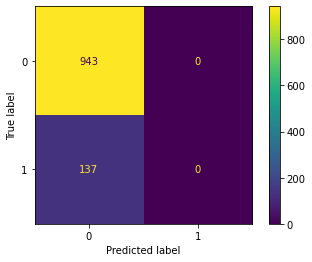

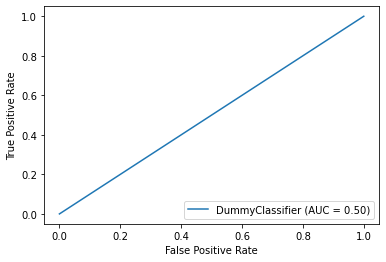

In [124]:
# Instantiate, fit, and run dummy model
dc = DummyClassifier(strategy="most_frequent", random_state=22)
dc.fit(X_train_smote, y_train_smote)
y_hat_train = dc.predict(X_train_smote)
y_hat_test = dc.predict(X_test_scaled)
print(f'Train: {classification_report(y_train_smote, y_hat_train, zero_division=0)}')
print(f'Test: {classification_report(y_test, y_hat_test, zero_division=0)}')

# Plot confusion matrix and ROC AUC for dummy model
plot_confusion_matrix(dc, X_test_scaled, y_test)
plot_roc_curve(dc, X_test_scaled, y_test);

Now that we have a baseline model, let us build a pipeline to streamline the rest of the modeling process

### Pipeline Construction

In [125]:
# Function with classifier input and pipeline output
def pipe_maker(classifier):
    pipe = imbPipeline([('scl', StandardScaler()), ('smt', SMOTE(random_state=22)), 
                        ('clf', classifier(random_state=22))])
    return pipe

In [126]:
# Function with Pipeline & Parameters input and gridsearch with optimum parameters output
def gridsearch_maker(pipeline, params):
    return GridSearchCV(estimator=pipeline,
                        param_grid=params,
                        scoring='accuracy',
                        cv=10,
                        n_jobs=-1)

In [127]:
# Function with pipline/gridsearch input and hyperparameters out for optimized accuracy
def best_acc(gridsearch):

    # Instantiate best_acc object
    best_acc = 0.0
    
    # Fit gridsearch to regularized data set
    gridsearch.fit(X_train, y_train)
    
    # Print best parameters
    print('Best paramaters are: %s' % gridsearch.best_params_)
    
    # Print best train accuracy_score
    print('Best training accuracy_score: %.3f' % gridsearch.best_score_)
    
    # Prediction on scaled test data
    y_hat_test = gridsearch.predict(X_test)
    
    # Print test data accuracy_score with best params
    print('Test accuracy_score with best parameters: %.3f ' % accuracy_score(y_test, y_hat_test))
    
    # Print confusion matrix and classification report
    print('Test: ', classification_report(y_test, y_hat_test, zero_division=0))
    
    # Plot confusion matrix and ROC AUC
    plot_confusion_matrix(gridsearch, X_test, y_test,cmap="plasma")
    plot_roc_curve(gridsearch, X_test, y_test);

Model away...

### Model 1: Logistic Regression Model

Best paramaters are: {'clf__dual': True, 'clf__max_iter': 1000, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Best training accuracy_score: 0.596
Test accuracy_score with best parameters: 0.609 
Test:                precision    recall  f1-score   support

           0       0.92      0.61      0.73       943
           1       0.19      0.62      0.29       137

    accuracy                           0.61      1080
   macro avg       0.55      0.61      0.51      1080
weighted avg       0.82      0.61      0.67      1080



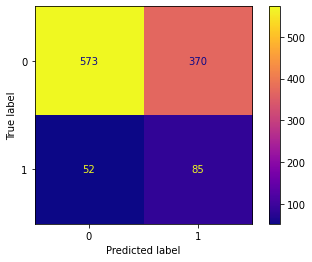

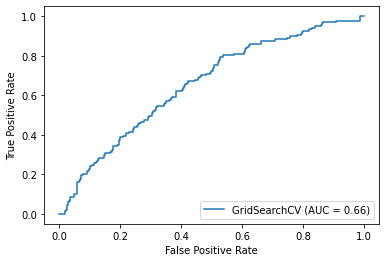

In [128]:
pipe_dt = pipe_maker(LogisticRegression)
grid_params_dt = [{'clf__penalty': ['l1', 'l2', 'elasticnet'],
                  'clf__solver': ['liblinear', 'saga'],
                  'clf__dual': [True, False],
                  'clf__max_iter': [1000,10000]}]
gs_dt = gridsearch_maker(pipe_dt, grid_params_dt)
best_acc(gs_dt)

Now we will quantify the risk factors by calling the coefficients on the optimized parameter model

In [129]:
# Instantiate, fit, and run model with best parameters
# Print odds ratios and identify top 5 risk factors
lr = LogisticRegression(max_iter=1000, dual=True, penalty='l2', solver='liblinear', random_state=22)
lr.fit(X_train_smote, y_train_smote)
print(np.exp(lr.coef_))
COEF = np.exp(lr.coef_[0])
odds = pd.DataFrame(COEF, X.columns, 
        columns=['odds']).sort_values(by='odds', ascending=False)
odds.head(10)

[[1.29186905 0.89882559 1.03352088 1.40693289 0.9753339  1.13601877
  1.37216494 0.92040707 0.99096484 0.87188633 0.94460359 1.06591349
  1.19393318 0.73982053 1.01618106 1.22610857 1.0494543  1.0208675
  0.84297338 1.1016542  0.86211764 0.91493856]]


,odds
PF,1.406933
HEIGHT,1.372165
MIN,1.291869
3P%,1.226109
NETRTG,1.193933
%AST,1.136019
%BLKA,1.101654
%BLK,1.065913
%STL,1.049454
%PFD,1.033521


Here we see the 5 most impactful prior season risk factors for sustaining season-ending injuries are:
1. Personal Fouls per Game
2. Height
3. Minutes per Season
4. 3 Point Field Goal Percentage
5. Net Rating

In [150]:
# Separate data into injured and noninjured cohorts
injured = df_con[(df_con['out_for_season']) == 1]
uninjured = df_con[(df_con['out_for_season']) == 0]

In [136]:
injured.describe()

,AGE,HEIGHT,WEIGHT,COLLEGE,COUNTRY,DRAFT ROUND,DRAFT NUMBER,GP,NETRTG,TS%,W,L,MPG,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,+/-,MIN,USG%,%FGM,%FGA,%3PM,%3PA,%FTM,%FTA,%OREB,%DREB,%REB,%AST,%TOV,%STL,%BLK,%BLKA,%PF,%PFD,%PTS,out_for_season,TEAM_ATL,TEAM_BKN,TEAM_BOS,TEAM_CHA,TEAM_CHI,TEAM_CLE,TEAM_DAL,TEAM_DEN,TEAM_DET,TEAM_GSW,TEAM_HOU,TEAM_IND,TEAM_LAC,TEAM_LAL,TEAM_MEM,TEAM_MIA,TEAM_MIL,TEAM_MIN,TEAM_NJN,TEAM_NOH,TEAM_NOP,TEAM_NYK,TEAM_OKC,TEAM_ORL,TEAM_PHI,TEAM_PHX,TEAM_POR,TEAM_SAC,TEAM_SAS,TEAM_TOR,TEAM_UTA,TEAM_WAS
count,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.00000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.0,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000
mean,26.768642,79.403442,223.026769,0.762906,0.759082,1.082218,16.581262,59.642447,-0.727151,0.536694,30.063098,29.57935,24.977820,10.968260,4.084704,8.934417,45.501912,0.821989,2.299618,28.108222,1.974379,2.586042,72.875526,1.112428,3.415105,4.528298,2.350096,1.470554,0.782600,0.521989,2.033078,22.363098,6.948375,0.164436,-0.016635,1570.315488,19.229637,19.652008,19.631549,18.424283,18.625430,19.623901,20.008987,20.602677,20.484895,20.560038,19.234417,19.060038,19.608987,20.438623,20.093690,20.630210,20.215296,19.622371,1.0,0.034417,0.032505,0.030593,0.040153,0.047801,0.028681,0.038241,0.043977,0.021033,0.034417,0.034417,0.024857,0.026769,0.034417,0.036329,0.026769,0.042065,0.049713,0.009560,0.009560,0.030593,0.038241,0.026769,0.032505,0.026769,0.038241,0.022945,0.036329,0.017208,0.021033,0.038241,0.024857
std,3.988250,3.650926,27.610163,0.425707,0.428050,0.524248,14.573193,19.855616,7.467559,0.061603,14.014697,12.64907,8.596248,6.160533,2.238362,4.707388,7.122513,0.748251,1.956901,15.995397,1.546047,1.891181,15.545546,0.895529,1.901013,2.648928,2.000923,0.813755,0.421254,0.517023,0.688657,10.679184,11.491260,0.988302,2.945861,804.920339,5.298795,5.765704,5.501391,14.168181,13.412419,10.270285,9.640073,14.938573,9.235571,10.026757,12.283501,6.580054,7.328212,17.074714,9.001189,6.673063,8.586874,5.900651,0.0,0.182472,0.177506,0.172376,0.196506,0.213550,0.167067,0.191961,0.205240,0.143630,0.182472,0.182472,0.155837,0.161561,0.182472,0.187286,0.161561,0.200930,0.217560,0.097401,0.097401,0.172376,0.191961,0.161561,0.177506,0.161561,0.191961,0.149870,0.187286,0.130172,0.143630,0.191961,0.155837
min,19.000000,69.000000,169.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-73.900000,0.000000,0.000000,0.00000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.600000,0.000000,0.000000,-9.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,77.000000,200.000000,1.000000,1.000000,1.000000,4.0000

In [137]:
uninjured.describe()

,AGE,HEIGHT,WEIGHT,COLLEGE,COUNTRY,DRAFT ROUND,DRAFT NUMBER,GP,NETRTG,TS%,W,L,MPG,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,+/-,MIN,USG%,%FGM,%FGA,%3PM,%3PA,%FTM,%FTA,%OREB,%DREB,%REB,%AST,%TOV,%STL,%BLK,%BLKA,%PF,%PFD,%PTS,out_for_season,TEAM_ATL,TEAM_BKN,TEAM_BOS,TEAM_CHA,TEAM_CHI,TEAM_CLE,TEAM_DAL,TEAM_DEN,TEAM_DET,TEAM_GSW,TEAM_HOU,TEAM_IND,TEAM_LAC,TEAM_LAL,TEAM_MEM,TEAM_MIA,TEAM_MIL,TEAM_MIN,TEAM_NJN,TEAM_NOH,TEAM_NOP,TEAM_NYK,TEAM_OKC,TEAM_ORL,TEAM_PHI,TEAM_PHX,TEAM_POR,TEAM_SAC,TEAM_SAS,TEAM_TOR,TEAM_UTA,TEAM_WAS
count,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.0,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000
mean,26.989193,79.125198,221.354771,0.836321,0.806273,1.052978,18.194781,51.452557,-2.334713,0.512923,25.722720,25.729837,19.548419,7.816342,2.931550,6.556036,43.584528,0.616289,1.768345,24.861650,1.341697,1.789141,69.728888,0.872035,2.539088,3.408355,1.724802,1.106906,0.615156,0.389457,1.707090,16.394333,3.863732,0.112283,-0.390933,1163.764628,17.986162,18.068635,18.571455,17.145809,18.040116,17.027201,17.592225,20.495572,19.585899,19.906036,17.941908,18.143358,19.215156,19.936083,19.040775,22.195203,18.107222,17.896732,0.0,0.032683,0.022667,0.033737,0.032683,0.029520,0.035846,0.034265,0.030575,0.032420,0.031892,0.032947,0.033474,0.034265,0.033737,0.036373,0.034001,0.033210,0.030311,0.012915,0.016078,0.019504,0.033210,0.034265,0.030838,0.035055,0.031365,0.032683,0.031629,0.035846,0.034792,0.031892,0.035319
std,4.298221,3.538852,26.473395,0.370033,0.395270,0.653198,16.362966,25.131985,12.361189,0.101652,16.150331,14.812904,9.382916,5.576685,2.037336,4.319536,10.128393,0.683934,1.786689,17.077545,1.288938,1.607527,20.313972,0.792561,1.724426,2.385627,1.732757,0.763123,0.425387,0.424357,0.751201,10.252441,8.744228,1.082927,2.922872,852.852917,5.165719,6.412772,5.876221,15.523572,14.568888,10.414460,10.099245,15.506795,8.770777,9.636700,12.708207,8.231485,10.067040,18.073105,11.522312,9.157542,8.960086,6.201951,0.0,0.177829,0.148860,0.180576,0.177829,0.169282,0.185931,0.181932,0.172185,0.177135,0.175737,0.178521,0.179894,0.181932,0.180576,0.187242,0.181256,0.179209,0.171464,0.112923,0.125792,0.138308,0.179209,0.181932,0.172902,0.183944,0.174326,0.177829,0.175033,0.185931,0.183276,0.175737,0.184609
min,19.000000,65.000000,133.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-150.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.800000,0.000000,0.000000,-19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

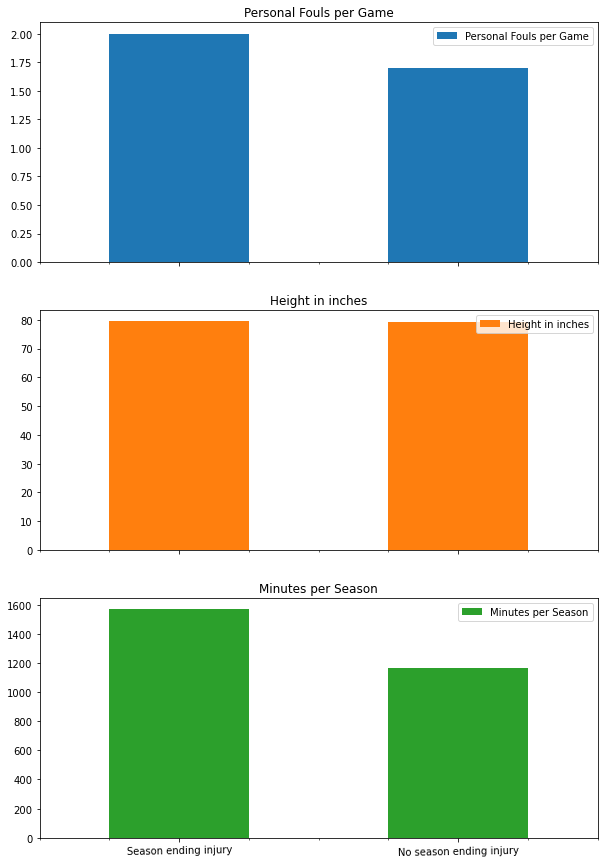

In [182]:
# Build chart
x=['Season ending injury','No season ending injury']
pf=[2.0,1.7]
height=[79.4,79.1]
minutes=[1570,1164]
r3 = pd.DataFrame({'Personal Fouls per Game':pf,'Height in inches':height,'Minutes per Season':minutes}, index=x)
axes = r3.plot.bar(rot=1, subplots=True, figsize=(10,15))
axes[1].legend(loc=1);

### Model 2: Random Forest Model

Best paramaters are: {'clf__class_weight': 'balanced_subsample', 'clf__criterion': 'entropy', 'clf__max_depth': 50}
Best training accuracy_score: 0.850
Test accuracy_score with best parameters: 0.840 
Test:                precision    recall  f1-score   support

           0       0.88      0.95      0.91       943
           1       0.23      0.11      0.15       137

    accuracy                           0.84      1080
   macro avg       0.55      0.53      0.53      1080
weighted avg       0.80      0.84      0.81      1080



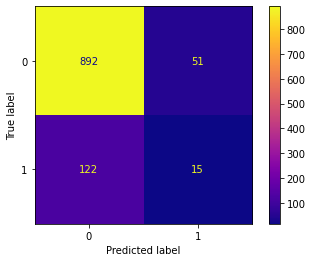

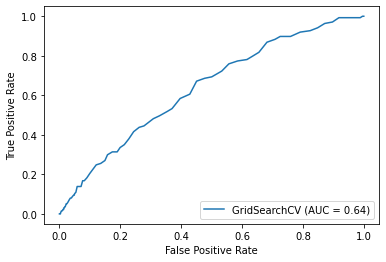

In [35]:
pipe_dt = pipe_maker(RandomForestClassifier)
grid_params_dt = [{'clf__criterion': ['gini', 'entropy'],
                  'clf__max_depth': [40,50,60],
                  'clf__class_weight': ['balanced', 'balanced_subsample']}]
gs_dt = gridsearch_maker(pipe_dt, grid_params_dt)
best_acc(gs_dt)

### Model 3: XGBoost Model

Best paramaters are: {'clf__booster': 'gbtree', 'clf__eta': 0, 'clf__max_depth': 4}
Best training accuracy_score: 0.881
Test accuracy_score with best parameters: 0.873 
Test:                precision    recall  f1-score   support

           0       0.87      1.00      0.93       943
           1       0.00      0.00      0.00       137

    accuracy                           0.87      1080
   macro avg       0.44      0.50      0.47      1080
weighted avg       0.76      0.87      0.81      1080



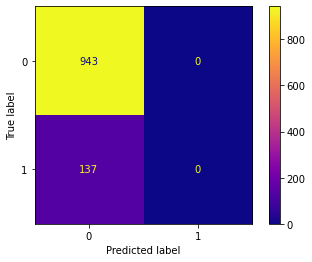

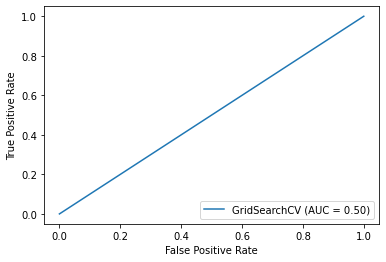

In [36]:
pipe_dt = pipe_maker(XGBClassifier)
grid_params_dt = [{'clf__booster': ['gbtree', 'gblinear', 'gbdart'],
                  'clf__eta': [0,1],
                  'clf__max_depth': [4,5,6]}]
gs_dt = gridsearch_maker(pipe_dt, grid_params_dt)
best_acc(gs_dt)

### Model 4: Naive Bayes Model

In [37]:
# Naive Bayes specific function with classifier input and pipeline output
def pipe_maker_bnb(classifier):
    pipe = imbPipeline([('scl', StandardScaler()), ('smt', SMOTE(random_state=22)), 
                        ('clf', classifier())])
    return pipe

Best paramaters are: {'clf__binarize': 0.75}
Best training accuracy_score: 0.649
Test accuracy_score with best parameters: 0.657 
Test:                precision    recall  f1-score   support

           0       0.90      0.69      0.78       943
           1       0.18      0.46      0.25       137

    accuracy                           0.66      1080
   macro avg       0.54      0.57      0.52      1080
weighted avg       0.81      0.66      0.71      1080



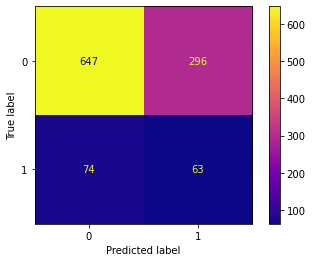

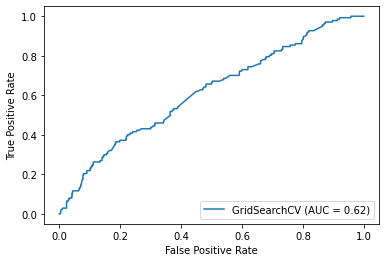

In [38]:
pipe_dt = pipe_maker_bnb(BernoulliNB)
grid_params_dt = [{'clf__binarize': [.5,.75,1]}]
gs_dt = gridsearch_maker(pipe_dt, grid_params_dt)
best_acc(gs_dt)

### Model 5: Combined Ensemble Model (Logistic Regression, Random Forest, XGBoost, Naive Bayes)

Train:               precision    recall  f1-score   support

           0       0.94      0.90      0.92      2851
           1       0.90      0.94      0.92      2851

    accuracy                           0.92      5702
   macro avg       0.92      0.92      0.92      5702
weighted avg       0.92      0.92      0.92      5702

Test:               precision    recall  f1-score   support

           0       0.90      0.80      0.85       943
           1       0.23      0.41      0.29       137

    accuracy                           0.75      1080
   macro avg       0.56      0.60      0.57      1080
weighted avg       0.82      0.75      0.78      1080



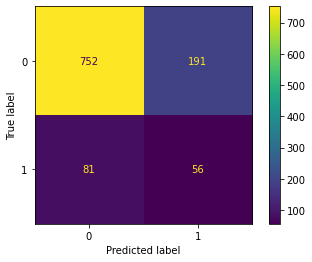

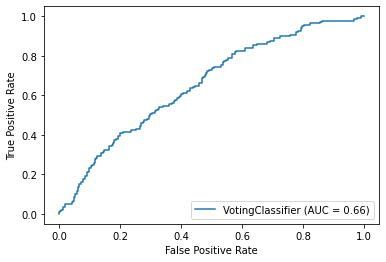

In [39]:
# Combined hypertuned prior models for ultimate ensemble
clf1 = LogisticRegression(max_iter=1000, dual=True, penalty='l2', solver='liblinear', random_state=22)
clf2 = RandomForestClassifier(class_weight='balanced', criterion='entropy', max_depth=50, random_state=22)
clf3 = XGBClassifier(booster='gbtree', eta=0, max_depth=4, random_state=22)
clf4 = BernoulliNB(binarize=.75)

w_avg = VotingClassifier(estimators=[
    ('lr', clf1),
    ('rf', clf2),
    ('xgb', clf3),
    ('bnb', clf4)],
     voting='soft')
w_avg.fit(X_train_smote, y_train_smote) 
y_hat_train = w_avg.predict(X_train_smote)
y_hat_test = w_avg.predict(X_test_scaled)
print(f'Train: {classification_report(y_train_smote, y_hat_train)}')
print(f'Test: {classification_report(y_test, y_hat_test)}')

# Plot confusion matrix and ROC AUC
plot_confusion_matrix(w_avg, X_test_scaled, y_test)
plot_roc_curve(w_avg, X_test_scaled, y_test);

### Comparing Models

In [40]:
LogReg = ['Logistic Regression', 0.61, 0.66, 0.29]
RanFor = ['Random Forest', 0.84, 0.64, 0.15]
XGBoost = ['XGBoost', 0.87, 0.5, 0]
Naive_Bayes = ['Naive Bayes', 0.66, 0.62, 0.25]
Combined = ['Combined Models', 0.75, 0.66, 0.29]
all_models = pd.DataFrame(list([LogReg,RanFor,XGBoost,Naive_Bayes,Combined]), 
                          columns=['Model','Accuracy','AUC', 'f1 score']).sort_values(['Accuracy'], ascending=False)
all_models

,Model,Accuracy,AUC,f1 score
2,XGBoost,0.87,0.50,0.00
1,Random Forest,0.84,0.64,0.15
4,Combined Models,0.75,0.66,0.29
3,Naive Bayes,0.66,0.62,0.25
0,Logistic Regression,0.61,0.66,0.29
